# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

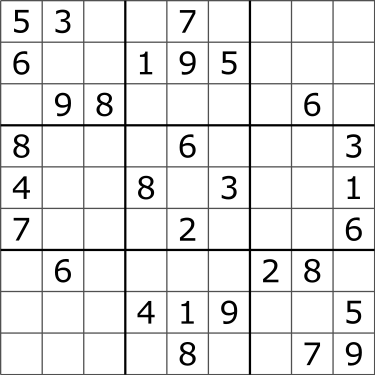

## Prepare environment

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from sudoku_solver.config.config import AppConfig
from sudoku_solver.data.dataset import prepare_dataset
from sudoku_solver.data.preprocess import (
    inverse_preprocess_input,
    inverse_preprocess_target,
)
from sudoku_solver.model.model import prepare_model
from sudoku_solver.model.training import train_model
from sudoku_solver.model.evaluation import (
    plot_histories,
    evaluate_on_difficulties,
    evaluate_replacing_fixed_positions,
    evaluate_puzzle,
    solve_sudoku
)

import numpy as np
import tensorflow as tf
import keras

# Uncomment for debugging
# tf.config.run_functions_eagerly(True)

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
#
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

E0000 00:00:1747134748.191922  229854 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747134748.198805  229854 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Hyperparameters

In [2]:
app_config = AppConfig.from_toml("sudoku_solver/config/base_config.toml")
app_config

AppConfig(DATA_SIZE_LIMIT=10000, BATCH_SIZE=256, LEARNING_RATE=0.001, EPOCHS=3, USE_RESIDUAL=True, USE_PRE_TRAINING=False, USE_DISK_CACHE=False, USE_CURRICULUM_LEARNING=True, CONSTRAINT_WEIGHT=0.1, FIXED_CELL_WEIGHT=10, USE_FIXED_NUMBER_LAYER=False, USE_DATASET_MIXING=False, PRIMARY_DATASET_SPLIT=0.9)

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(
    app_config.BATCH_SIZE,
    size_limit=app_config.DATA_SIZE_LIMIT,
    use_disk_cache=app_config.USE_DISK_CACHE,
)

Trying to prepare dataset from disk


I0000 00:00:1747134756.207880  229854 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Dataset ready.


Measuring pipeline performance...:   0%|          | 3/1000 [00:00<00:56, 17.74it/s]

Average batch fetch time is: 0.14121723175048828


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        print(inverse_preprocess_input(X))
        print(inverse_preprocess_target(y))
        break

Validate dataset pipeline:

tf.Tensor(
[[1. 4. 9. 7. 2. 5. 3. 8. 6.]
 [0. 0. 5. 3. 9. 8. 1. 4. 7.]
 [7. 3. 8. 4. 1. 6. 9. 5. 2.]
 [8. 7. 3. 9. 6. 2. 4. 0. 5.]
 [0. 6. 4. 1. 5. 3. 7. 9. 8.]
 [5. 9. 0. 0. 4. 7. 6. 2. 3.]
 [3. 1. 7. 0. 8. 9. 2. 6. 4.]
 [4. 0. 2. 6. 3. 1. 5. 7. 9.]
 [9. 0. 0. 2. 0. 4. 8. 3. 1.]], shape=(9, 9), dtype=float64)
tf.Tensor(
[[ 1  4  9  7  2  5  3  8  6]
 [16 12  5  3  9  8  1  4  7]
 [ 7  3  8  4  1  6  9  5  2]
 [ 8  7  3  9  6  2  4 11  5]
 [12  6  4  1  5  3  7  9  8]
 [ 5  9 11 18  4  7  6  2  3]
 [ 3  1  7 15  8  9  2  6  4]
 [ 4 18  2  6  3  1  5  7  9]
 [ 9 15 16  2 17  4  8  3  1]], shape=(9, 9), dtype=int32)


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

3

## Train model

### Prepare model

In [6]:
model = prepare_model(
    use_residual=app_config.USE_RESIDUAL,
    use_fixed_number_layer=app_config.USE_FIXED_NUMBER_LAYER,
    learning_rate=app_config.LEARNING_RATE,
    constraint_weight=app_config.CONSTRAINT_WEIGHT,
    fixed_cell_weight=app_config.FIXED_CELL_WEIGHT,
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 9, 9, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]     

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
histories = train_model(model, train_datasets, val_dataset, app_config)

Train on difficulty 0
Resetting learning rate to: 0.0005
Previous constraint loss weight: 0.1
Previous fixed cell loss weight: 10.0
New constraint loss weight: 0.1
New fixed cell loss weight: 10.0
Epoch 1/3


I0000 00:00:1747134767.354708  229947 service.cc:148] XLA service 0x7f510c004720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747134767.354776  229947 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
W0000 00:00:1747134767.496290  229947 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1747134768.689762  229947 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1747134785.685823  229947 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1097 - box_penalty: 0.1281 - col_penalty: 0.1360 - loss: 9.4053 - row_penalty: 0.1292

W0000 00:00:1747134787.049636  229948 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert



Penalties:
crossentropy_tracker:  0.29163593
total_penalty_tracker:  0.03170537
row_penalty_tracker:  0.10331439
col_penalty_tracker:  0.10960586
box_penalty_tracker:  0.10413344
cell_penalty_tracker:  8.923778
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1099 - box_penalty: 0.1307 - col_penalty: 0.1385 - loss: 9.4296 - row_penalty: 0.1314 - val_accuracy: 0.1118 - val_box_penalty: 1.9661e-04 - val_col_penalty: 2.1730e-04 - val_loss: 9.0264 - val_row_penalty: 1.9916e-04 - learning_rate: 5.0000e-04
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1388 - box_penalty: 0.1349 - col_penalty: 0.1423 - loss: 9.4227 - row_penalty: 0.1506
Penalties:
crossentropy_tracker:  0.30765304
total_penalty_tracker:  0.031975936
row_penalty_tracker:  0.107925095
col_penalty_tracker:  0.108315565
box_penalty_tracker:  0.1035187
cell_penalty_tracker:  8.877011
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step - accuracy: 0.1385 - box_penalty: 0.1355 - col_penalty: 0.1424 - loss: 9.4220 - row_penalt

### Save model

In [8]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

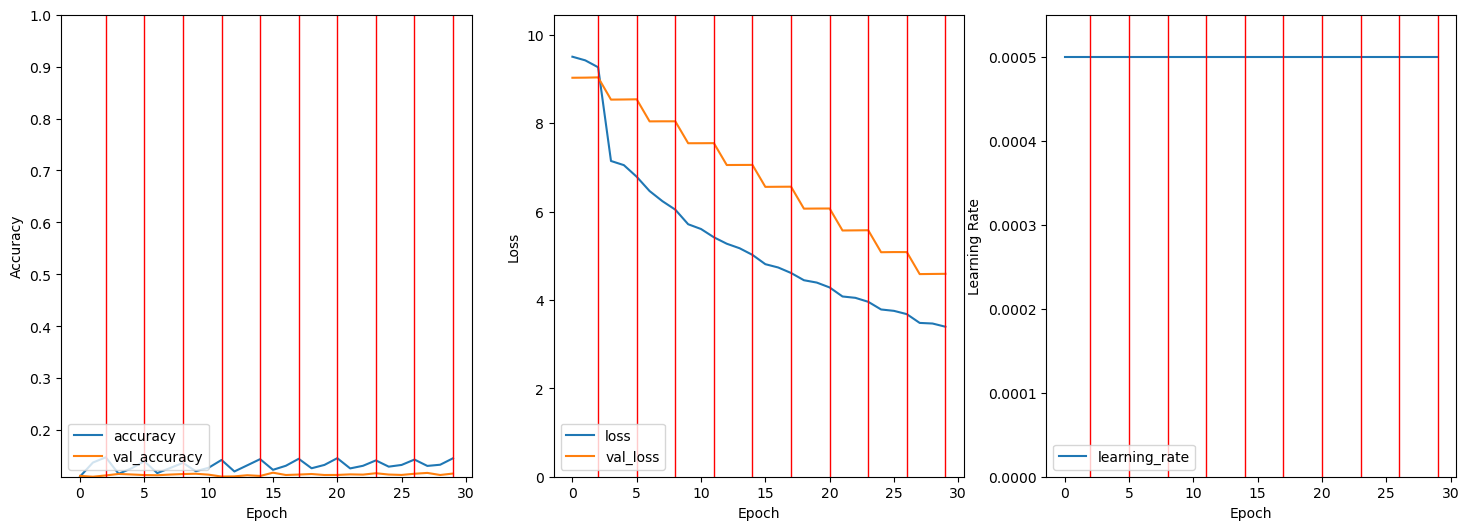

In [9]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [10]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [18]:
evaluate_puzzle(model,
    (
        "800250704"
        "420000000"
        "000008065"
        "000045300"
        "004603100"
        "007910000"
        "540700000"
        "000000089"
        "209086001"
    ),
    (
        "863259714"
        "425167938"
        "791438265"
        "612845397"
        "984673152"
        "357912846"
        "548791623"
        "176324589"
        "239586471"
    ),
)


Puzzle:
8 0 0 2 5 0 7 0 4
4 2 0 0 0 0 0 0 0
0 0 0 0 0 8 0 6 5
0 0 0 0 4 5 3 0 0
0 0 4 6 0 3 1 0 0
0 0 7 9 1 0 0 0 0
5 4 0 7 0 0 0 0 0
0 0 0 0 0 0 0 8 9
2 0 9 0 8 6 0 0 1

Actual solution:
8 6 3 2 5 9 7 1 4
4 2 5 1 6 7 9 3 8
7 9 1 4 3 8 2 6 5
6 1 2 8 4 5 3 9 7
9 8 4 6 7 3 1 5 2
3 5 7 9 1 2 8 4 6
5 4 8 7 9 1 6 2 3
1 7 6 3 2 4 5 8 9
2 3 9 5 8 6 4 7 1

Predicted solution:
3 8 6 9 9 9 8 9 2
8 9 1 8 4 1 8 7 1
2 2 7 1 6 3 4 5 7
6 5 5 4 6 7 2 3 4
9 8 2 6 1 1 6 5 1
1 2 2 1 6 6 7 8 3
9 2 6 2 6 3 6 7 4
9 7 6 3 4 6 2 7 6
8 9 3 4 1 1 9 8 9

Accuracy on puzzle with 30 non-zero numbers is 0.12345679104328156


In [12]:
evaluate_puzzle(model,
    (
        "400510607"
        "050007020"
        "300020041"
        "035960000"
        "600400015"
        "014002008"
        "060075093"
        "001000700"
        "703098052"
    ),
    (
        "482519637"
        "156347829"
        "379826541"
        "835961274"
        "627483915"
        "914752368"
        "268175493"
        "591234786"
        "743698152"
    ),
)


Puzzle:
4 0 0 5 1 0 6 0 7
0 5 0 0 0 7 0 2 0
3 0 0 0 2 0 0 4 1
0 3 5 9 6 0 0 0 0
6 0 0 4 0 0 0 1 5
0 1 4 0 0 2 0 0 8
0 6 0 0 7 5 0 9 3
0 0 1 0 0 0 7 0 0
7 0 3 0 9 8 0 5 2

Actual solution:
4 8 2 5 1 9 6 3 7
1 5 6 3 4 7 8 2 9
3 7 9 8 2 6 5 4 1
8 3 5 9 6 1 2 7 4
6 2 7 4 8 3 9 1 5
9 1 4 7 5 2 3 6 8
2 6 8 1 7 5 4 9 3
5 9 1 2 3 4 7 8 6
7 4 3 6 9 8 1 5 2

Predicted solution:
3 8 6 9 9 9 8 5 2
5 6 4 8 4 1 8 6 1
9 9 7 1 6 3 3 8 7
6 5 5 4 5 2 2 3 4
9 6 2 6 1 1 6 5 1
1 2 4 1 6 6 7 8 3
1 2 6 7 6 3 6 7 4
9 7 6 3 4 6 2 7 6
8 9 1 4 1 8 7 8 2

Accuracy on puzzle with 37 non-zero numbers is 0.1358024775981903


### Evaluate on different difficulties

In [13]:
evaluate_on_difficulties(model, train_datasets)

W0000 00:00:1747134858.073694  229949 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


Difficulty 1: loss=1.375307035446167, accuracy=0.034968172758817674
Average non-zero numbers in puzzle in one batch: 20

Difficulty 2: loss=1.3758157253265382, accuracy=0.0341242291033268
Average non-zero numbers in puzzle in one batch: 14

Difficulty 3: loss=1.3759727001190185, accuracy=0.03433159813284874
Average non-zero numbers in puzzle in one batch: 13

Difficulty 4: loss=1.375965166091919, accuracy=0.03401813358068466
Average non-zero numbers in puzzle in one batch: 12

Difficulty 5: loss=1.3759878635406495, accuracy=0.03319830372929573
Average non-zero numbers in puzzle in one batch: 12

Difficulty 6: loss=1.37566819190979, accuracy=0.03427372723817825
Average non-zero numbers in puzzle in one batch: 11

Difficulty 7: loss=1.375636911392212, accuracy=0.034693286567926404
Average non-zero numbers in puzzle in one batch: 11

Difficulty 8: loss=1.3757014274597168, accuracy=0.03463541641831398
Average non-zero numbers in puzzle in one batch: 10

Difficulty 9: loss=1.375971126556396

### Evaluate test set performance

In [14]:
loss, accuracy, *rest = model.evaluate(test_dataset)

W0000 00:00:1747134866.604406  229950 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1145 - box_penalty: 9.9226e-04 - col_penalty: 0.0013 - loss: 4.5852 - row_penalty: 0.0011


In [15]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.11453510820865631 and loss: 4.585247039794922


### Evaluate after replacing fixed positions with fixed numbers

In [16]:
evaluate_replacing_fixed_positions(model, test_dataset)

Test Set Accuracy after copying Fixed Numbers: 0.54046100


The End